In [ ]:
# Safe setup cell: run ini di awal sekali
!pip uninstall -y numpy ta pandas tensorflow
!pip install numpy==1.23.5 pandas==1.5.3 ta==0.10.2 tensorflow==2.12.0 --no-cache-dir --force-reinstall
!pip install ccxt smartmoneyconcepts tradingview_ta --quiet

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 41.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
google-colab 1.0.0 requires pand

<ipython-input-13-a2ca6072e340>:97: RuntimeWarning: divide by zero encountered in scalar divide
  change = (future_avg - current) / current


Epoch 1/50
28/28 [==============================] - 5s 63ms/step - loss: 1.6692 - accuracy: 0.5535 - val_loss: 1.3028 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 1s 41ms/step - loss: 1.1828 - accuracy: 0.6056 - val_loss: 1.0217 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 1s 38ms/step - loss: 0.9629 - accuracy: 0.6235 - val_loss: 0.8662 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 2s 55ms/step - loss: 0.8337 - accuracy: 0.6174 - val_loss: 0.7553 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 2s 63ms/step - loss: 0.7341 - accuracy: 0.6527 - val_loss: 0.6660 - val_accuracy: 0.7472 - lr: 0.0010
Epoch 6/50
28/28 [==============================] - 1s 39ms/step - loss: 0.6593 - accuracy: 0.7098 - val_loss: 0.6019 - val_accuracy: 0.7472 - lr: 0.0010
Epoch 7/50
28/28 [==============================] - 1s 41ms/step - loss: 0.6

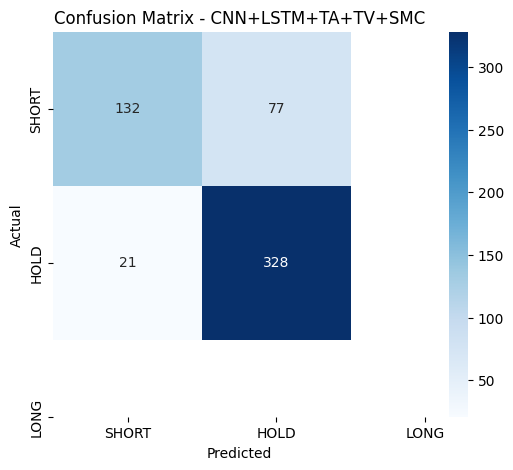

✅ Akurasi total: 82.44%


In [13]:
# STEP 1: IMPORT
import ccxt
import pandas as pd
import numpy as np
from smartmoneyconcepts import smc
import ta
from tradingview_ta import TA_Handler, Interval, Exchange
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 2: CONFIG
symbols = ['BTC/USDT', 'ETH/USDT', 'SOL/USDT']
timeframe = '1h'
limit = 3000
sequence_len = 60
forward_window = 3
threshold = 0.003

# STEP 3: FETCH BITGET DATA
def fetch_bitget_data(symbol, timeframe='1h', limit=3000):
    exchange = ccxt.bitget({'enableRateLimit': True})
    df = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(df, columns=['timestamp','open','high','low','close','volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Asia/Jakarta').dt.tz_localize(None)  # ✅
    df['symbol'] = symbol
    return df

# STEP 4: TRADINGVIEW RECOMMENDATION
def get_tv_recommendation(symbol='BTCUSDT'):
    handler = TA_Handler(
        symbol=symbol,
        screener="crypto",
        exchange="BINANCE",
        interval=Interval.INTERVAL_1_HOUR
    )
    analysis = handler.get_analysis()
    rec = analysis.summary['RECOMMENDATION']
    return {'BUY': rec in ['BUY', 'STRONG_BUY'], 'SELL': rec in ['SELL', 'STRONG_SELL'], 'NEUTRAL': rec == 'NEUTRAL'}

# STEP 5: ADD FEATURES
def add_features(df):
    df['return'] = df['close'].pct_change()

    ema14 = ta.trend.EMAIndicator(close=df['close'], window=14)
    df['ema14'] = ema14.ema_indicator()

    ema50 = ta.trend.EMAIndicator(close=df['close'], window=50)
    df['ema50'] = ema50.ema_indicator()

    df['ema_slope'] = df['ema14'].diff()

    rsi = ta.momentum.RSIIndicator(close=df['close'], window=14)
    df['rsi'] = rsi.rsi()
    df['rsi_slope'] = df['rsi'].diff()
    df['volatility'] = df['high'] - df['low']
    df['body'] = abs(df['close'] - df['open'])
    df['btr'] = df['body'] / (df['volatility'] + 1e-6)
    df['doji'] = (df['btr'] < 0.1).astype(int)
    df['engulfing'] = ((df['close'].shift(1) < df['open'].shift(1)) &
                       (df['close'] > df['open']) &
                       (df['close'] > df['open'].shift(1)) &
                       (df['open'] < df['close'].shift(1))).astype(int)
    df['hammer'] = ((df['high'] - df['low'] > 3 * df['body']) &
                    ((df['close'] - df['low']) / (df['high'] - df['low'] + 1e-6) > 0.6)).astype(int)
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek

    # SMC Features
    ohlc = df[['open', 'high', 'low', 'close']].copy()
    swings = smc.swing_highs_lows(ohlc, swing_length=50)
    bos_choch = smc.bos_choch(ohlc, swings)
    fvg = smc.fvg(ohlc, join_consecutive=True)

    # Tambahkan ke df dengan nama kapital
    df['BOS'] = bos_choch['BOS'].reindex(df.index).fillna(0).astype(int)
    df['CHoCH'] = bos_choch['CHOCH'].reindex(df.index).fillna(0).astype(int)
    df['FVG'] = fvg['FVG'].reindex(df.index).fillna(0).astype(int)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df.dropna()

# STEP 6: LABEL 3 CLASS
def label_direction(df, forward=3, threshold=0.003):
    y = []
    closes = df['close'].values
    for i in range(len(df) - forward):
        future_avg = np.mean(closes[i+1:i+1+forward])
        current = closes[i]
        change = (future_avg - current) / current
        if change > threshold:
            y.append(2)  # LONG
        elif change < -threshold:
            y.append(0)  # SHORT
        else:
            y.append(1)  # HOLD
    return y

# STEP 7: SEQUENCE
def prepare_sequences(df, features, seq_len=60, fwd=3, threshold=0.003):
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])
    y_labels = label_direction(df, fwd, threshold)
    X, y = [], []
    for i in range(len(y_labels) - seq_len):
        X.append(df[features].iloc[i:i+seq_len].values)
        y.append(y_labels[i+seq_len])
    return np.array(X), np.array(y)

# STEP 8: LOAD & COMBINE DATA
all_data = []
for sym in symbols:
    df = fetch_bitget_data(sym)
    df = add_features(df)
    all_data.append(df)
df_all = pd.concat(all_data).sort_values('timestamp')

features = ['open','high','low','close','volume','return','ema14','ema50','ema_slope',
            'rsi','rsi_slope','volatility','body','btr','doji','engulfing','hammer',
            'hour','dayofweek','BOS','CHoCH','FVG']

X, y = prepare_sequences(df_all, features, sequence_len, forward_window, threshold)
y_cat = to_categorical(y, num_classes=3)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# STEP 9: MODEL
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X.shape[1], X.shape[2]), padding='same'),
    MaxPooling1D(2),
    Dropout(0.2),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5)
]

# STEP 10: TRAIN
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=callbacks, verbose=1)

# STEP 11: EVALUATE
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred, output_dict=True)
cm = confusion_matrix(y_true, y_pred)

# STEP 12: CONFUSION MATRIX
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['SHORT','HOLD','LONG'], yticklabels=['SHORT','HOLD','LONG'])
plt.title("Confusion Matrix - CNN+LSTM+TA+TV+SMC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"✅ Akurasi total: {report['accuracy']*100:.2f}%")

In [26]:
model.save('model_trading_ai.keras')

In [24]:
def get_tf_config(timeframe):
    config_map = {
        '5m': {       # 🔪 SCALPING
            'limit': 1500,            # ~5 hari data
            'sequence_len': 60,       # 5 jam input
            'forward': 6              # prediksi 30 menit ke depan
        },
        '15m': {      # ⚡ INTRADAY
            'limit': 2000,            # ~20 hari data
            'sequence_len': 64,       # 16 jam input
            'forward': 4              # prediksi 1 jam ke depan
        },
        '1h': {       # ⚖️ HYBRID / Default
            'limit': 2000,
            'sequence_len': 48,       # 2 hari input
            'forward': 3              # prediksi 3 jam ke depan
        },
        '4h': {       # 🎯 SWING
            'limit': 1000,            # ~6 bulan data
            'sequence_len': 32,       # ~5 hari input
            'forward': 2              # prediksi 8 jam ke depan
        },
        '1d': {       # 📦 POSITION
            'limit': 700,             # ~2 tahun data
            'sequence_len': 30,       # 1 bulan input
            'forward': 2              # prediksi 2 hari ke depan
        }
    }
    return config_map.get(timeframe, config_map['1h'])  # default ke 1h kalau gak ketemu

def explain_reason(df, index=-1):
    row = df.iloc[index]
    reasons = []
    active_signals = 0

    if row.get('engulfing', 0) == 1:
        reasons.append("Terdeteksi pola Bullish Engulfing")
        active_signals += 1
    if row.get('doji', 0) == 1:
        reasons.append("Candle Doji menunjukkan kebimbangan market")
        active_signals += 1
    if row.get('ema14', 0) > row.get('ema50', 0):
        reasons.append("EMA 14 berada di atas EMA 50 (tren naik jangka pendek)")
        active_signals += 1
    if row.get('rsi', 0) > 60:
        reasons.append(f"RSI tinggi ({row['rsi']:.1f}) menunjukkan tekanan beli")
        active_signals += 1
    elif row.get('rsi', 0) < 40:
        reasons.append(f"RSI rendah ({row['rsi']:.1f}) menunjukkan tekanan jual")
        active_signals += 1
    if row.get('BOS', 0) == 1:
        reasons.append("Break of Structure terkonfirmasi")
        active_signals += 1
    if row.get('FVG', 0) == 1:
        reasons.append("Fair Value Gap aktif di sekitar harga")
        active_signals += 1

    # LEVEL 1: Skor Teknis
    score_pct = active_signals / 6 * 100
    if active_signals >= 4:
        rating = f"Sinyal teknikal **KUAT** ({active_signals}/6 indikator aktif = {score_pct:.0f}%)"
    elif active_signals >= 2:
        rating = f"Sinyal teknikal **MODERAT** ({active_signals}/6 indikator aktif = {score_pct:.0f}%)"
    elif active_signals == 1:
        rating = f"Sinyal teknikal **LEMAH** (1/6 indikator aktif = 17%)"
    else:
        rating = "Tidak ada sinyal teknikal dominan"

    # LEVEL 2: Summary Kalimat Natural
    if active_signals == 0:
        summary = "Model memprediksi arah market tanpa dukungan sinyal teknikal dominan."
    else:
        summary = f"Model memprediksi arah market dengan dukungan {active_signals} indikator aktif seperti: " + "; ".join(reasons[:3]) + ("." if len(reasons) <= 3 else ", dll.")

    return reasons, rating, summary, score_pct


def predict_direction(model, df_raw, features, sequence_len=60):
    df_feat = add_features(df_raw.copy()).dropna()
    scaler = MinMaxScaler()
    df_feat[features] = scaler.fit_transform(df_feat[features])
    if len(df_feat) < sequence_len:
        raise ValueError("Not enough data for the required sequence length.")

    seq_input = df_feat[features].iloc[-sequence_len:].values
    seq_input = np.expand_dims(seq_input, axis=0)

    pred_prob = model.predict(seq_input)
    pred_class = np.argmax(pred_prob, axis=1)[0]

    label_map = {0: 'SHORT', 1: 'WAIT', 2: 'LONG'}
    probs = pred_prob[0]

    # Balikin df_feat & df_raw dua-duanya
    return label_map[pred_class], {
        'SHORT': probs[0],
        'WAIT' : probs[1],
        'LONG' : probs[2]
    }, df_feat, df_raw

def predict_with_plan(symbol, timeframe):
    cfg = get_tf_config(timeframe)
    df_raw = fetch_bitget_data(symbol, timeframe, limit=cfg['limit'])
    direction, probs, df_feat, df_raw = predict_direction(model, df_raw, features, sequence_len=cfg['sequence_len'])

    # Ambil harga asli dari df_raw, bukan df_feat
    last_candle_feat = df_feat[df_feat['timestamp'] == df_feat['timestamp'].max()].iloc[0]
    last_candle_raw  = df_raw[df_raw['timestamp'] == last_candle_feat['timestamp']].iloc[0]
    price = last_candle_raw['close']
    ts = last_candle_raw['timestamp'].strftime("%Y-%m-%d %H:%M")
    atr = last_candle_raw['high'] - last_candle_raw['low']
    sl_buffer = atr * 0.5
    tp_buffer = atr * 1.2

    if direction == 'LONG':
        entry = price
        sl = price - sl_buffer
        tp = price + tp_buffer
    elif direction == 'SHORT':
        entry = price
        sl = price + sl_buffer
        tp = price - tp_buffer
    else:
        entry = price
        sl = tp = None

    reasons, rating, summary, score_pct = explain_reason(df_feat)
    result = {
        'timeframe': timeframe,
        'timestamp': ts,
        'direction': direction,
        'confidence': {
          'SHORT': probs['SHORT']*100,
          'WAIT' : probs['WAIT']*100,
          'LONG' : probs['LONG']*100,
        },
        'entry': entry,
        'sl': sl,
        'tp': tp,
        'reasons': reasons,
        'rating': rating,
        'summary': summary,
        'reason_score': score_pct,  # LEVEL 1 - optional untuk reinforcement learning
    }

    # LEVEL 3: Optional Trigger Logic
    if direction == 'LONG' and score_pct >= 67 and result['confidence']['LONG'] > 70:
        print("🚨 AUTO ALERT: Sinyal LONG KUAT Terdeteksi!")
    elif direction == 'SHORT' and score_pct >= 67 and result['confidence']['SHORT'] > 70:
        print("🚨 AUTO ALERT: Sinyal SHORT KUAT Terdeteksi!")

    return result

def multi_tf_predict_with_plan(symbol):
    tf_modes = {
        '🔪 SCALPING': '5m',
        '⚡ INTRADAY': '15m',
        '🎯 SWING': '4h',
        '📦 POSITION': '1d',
    }

    print(f"📌 Symbol: {symbol}\n")
    for label, tf in tf_modes.items():
        res = predict_with_plan(symbol, tf)
        print(f"{label} (TF: {res['timeframe']})")
        print(f"🕒 Candle: {res['timestamp']}")
        print(f"📈 Prediksi: {res['direction']}")
        print("🧠 Alasan Prediksi:")
        for r in res['reasons']:
            print(f" - {r}")
        print(f"⚖️ Kekuatan Sinyal: {res['rating']}")
        print(f"🧾 Ringkasan: {res['summary']}")
        print(f"🔢 Confidence:")
        print(f"  - SHORT: {res['confidence']['SHORT']:.2f}%")
        print(f"  - WAIT : {res['confidence']['WAIT']:.2f}%")
        print(f"  - LONG : {res['confidence']['LONG']:.2f}%")
        print(f"💰 Entry: {res['entry']:.2f}")
        if res['sl'] is not None:
            print(f"🛡️ SL: {res['sl']:.2f}")
            print(f"🎯 TP: {res['tp']:.2f}")
        else:
            print("📛 Belum ada setup konfirmasi (WAIT)")
        print('-'*40)

In [25]:
multi_tf_predict_with_plan('BTC/USDT')

📌 Symbol: BTC/USDT

1/1 [==============================] - 0s 25ms/step
🔪 SCALPING (TF: 5m)
🕒 Candle: 2025-06-07 08:05
📈 Prediksi: LONG
🧠 Alasan Prediksi:
 - EMA 14 berada di atas EMA 50 (tren naik jangka pendek)
 - RSI rendah (0.4) menunjukkan tekanan jual
 - Break of Structure terkonfirmasi
⚖️ Kekuatan Sinyal: Sinyal teknikal **MODERAT** (3/6 indikator aktif = 50%)
🧾 Ringkasan: Model memprediksi arah market dengan dukungan 3 indikator aktif seperti: EMA 14 berada di atas EMA 50 (tren naik jangka pendek); RSI rendah (0.4) menunjukkan tekanan jual; Break of Structure terkonfirmasi.
🔢 Confidence:
  - SHORT: 24.69%
  - WAIT : 0.00%
  - LONG : 75.30%
💰 Entry: 104880.81
🛡️ SL: 104879.10
🎯 TP: 104884.90
----------------------------------------
1/1 [==============================] - 0s 32ms/step
⚡ INTRADAY (TF: 15m)
🕒 Candle: 2025-06-07 08:00
📈 Prediksi: LONG
🧠 Alasan Prediksi:
 - EMA 14 berada di atas EMA 50 (tren naik jangka pendek)
 - RSI rendah (0.6) menunjukkan tekanan jual
⚖️ Kekuatan 